# Monet-Style Photos using CycleGANs

### Garrett Bainwol
[Github Repository Link](https://github.com/gbainwol/DTSA_5511_KAGGLE_WEEK_5_GAN)

**Overview** 

We will use a CycleGANs architecture in this project to convert photographs to a Monet-inspired format. 300 Monet paintings and 7,038 images make up the dataset's picture set. Each of these 256x256 pixel images has three channels with eight bits each for the red, green, and blue values (making it a 24-bit 256x256 image).

**The GAN**


The generative adversarial network (GAN) class of machine learning frameworks was developed in June 2014 by Ian Goodfellow and his coworkers.  Two neural networks compete with one another in a zero-sum game, where one agent profits at the expense of the other.


After obtaining a training set, this approach develops the capacity to generate new data with the same statistics as the training set. For instance, a GAN trained on photos can create new images that, at the very least, have many realistic features and seem legitimate to human observers. GANs have proven successful for reinforcement learning, fully supervised learning, and semi-supervised learning, while being initially presented as a form of generative model for unsupervised learning.

The foundation of a GAN is based on "indirect" training through the discriminator, a different neural network that may assess how "realistic" the input seems and that is also dynamically updated. This indicates that the generator is taught to trick the discriminator rather than to reduce the distance to a particular image. This makes it possible for the model to learn without supervision.





**CycleGAN**

CycleGAN seeks to address the issue of image-to-image translation. The objective of the image-to-image translation problem is to learn the mapping between an input image and an output image using a training set of aligned image pairings. On the other hand, getting paired samples isn't always possible. CycleGAN seeks to learn this mapping without requiring paired input-output images by using cycle-consistent adversarial networks.

In [1]:
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Library Imports 

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
import os
import random


2022-11-29 19:42:39.388354: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-11-29 19:42:39.388535: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
#TPU Setup
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Device: grpc://10.0.0.2:8470


2022-11-29 19:42:44.617645: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-29 19:42:44.620446: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-11-29 19:42:44.620478: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-29 19:42:44.620500: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (6711e872bc3e): /proc/driver/nvidia/version does not exist
2022-11-29 19:42:44.623472: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8
2.4.1


**Loading the Dataest**

We want to separate our photo dataset from our Monet dataset.

In [4]:
RANDOM_SEED = 42
IMAGE_SIZE = [256, 256]
OUTPUT_CHANNELS = 3
INITIAL_MEAN = 0.0
INITIAL_STD_DEV = 0.05 #0.02

#DATA_DIR = "./data"
#TEMP_DIR = "./fake_monets"
DATA_DIR = KaggleDatasets().get_gcs_path()
TEMP_DIR = "/kaggle/temp/"

MONET_FILENAMES = tf.io.gfile.glob(os.path.join(DATA_DIR + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))
print("Monet images:", sum(1 for _ in tf.data.TFRecordDataset(MONET_FILENAMES)))

PHOTO_FILENAMES = tf.io.gfile.glob(os.path.join(DATA_DIR + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))
print("Photo images:", sum(1 for _ in tf.data.TFRecordDataset(PHOTO_FILENAMES)))

KERNEL_INITIALIZER = tf.random_normal_initializer(INITIAL_MEAN, INITIAL_STD_DEV, seed = RANDOM_SEED)
#KERNEL_INITIALIZER = tf.random_uniform_initializer(minval= 0.0, maxval = 1.0, seed = RANDOM_SEED)
GAMMA_INTIALIZER = keras.initializers.RandomNormal(mean = INITIAL_MEAN, stddev = INITIAL_STD_DEV, seed = RANDOM_SEED)

2022-11-29 19:42:51.768998: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Monet TFRecord Files: 5
Monet images: 300
Photo TFRecord Files: 20


2022-11-29 19:42:53.507774: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-11-29 19:42:53.510915: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 315, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1669750973.506983033","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 315, Output num: 0","grpc_status":3}


Photo images: 7038


# Exploratory Data Analysis(EDA)

The sample collection of regular images and monet-style photos from their respective databases will be generated by the following lines of code.

In [5]:
#Image Helper Functions
def encodeImage(image):
    image = tf.image.decode_jpeg(image, channels=3)
    #As the RGB values vary from 0 to 255 inclusive, this next
    #line will alter the values to range from -1 to 1 for training
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def decodeImage(image, maxValue = 1):
    #This converts the -1 to 1 values to 0 to 1 for use with imshow
    image = (image * 0.5) + 0.5
    if maxValue == 255:
        #This converts the now 0 to 1 values to 0 to 255 for use with
        #PIL.Image when saving as a JPEG for submission to Kaggle
        image = (image * 255).astype(np.uint8)
    
    return image
    

def read_tfrecord(record):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    record = tf.io.parse_single_example(record, tfrecord_format)
    image = encodeImage(record['image'])
    return image

In [6]:
def load_dataset(filenames, labeled = True, ordered = False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls = AUTOTUNE)
    return dataset

monet_ds = load_dataset(MONET_FILENAMES, labeled = True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled = True).batch(1)

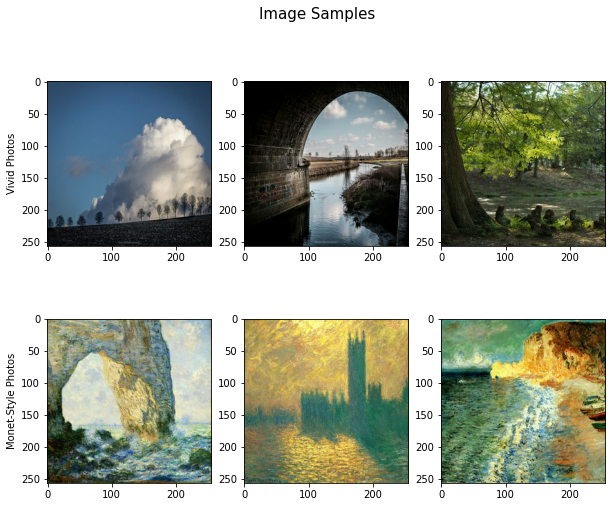

In [7]:
numImages = 3
def makeImageRow(ax, row, ds, generate = True):
    for i, image in enumerate(ds.take(numImages)):
        ax[row, i].imshow(decodeImage(image[0]))
        if generate:
            prediction = m_generator(image, training = False)[0].numpy()
            ax[1, i].imshow(decodeImage(prediction))

def showSamples():       
    fig, ax = plt.subplots(2, numImages, figsize = (10, 8))
    fig.suptitle('Image Samples', fontsize = 15)

    makeImageRow(ax, 0, photo_ds, generate = False)
    makeImageRow(ax, 1, monet_ds, generate = False)
    ax[0, 0].set_ylabel('Vivid Photos', fontsize='10')
    ax[1, 0].set_ylabel('Monet-Style Photos',  fontsize='10')

    plt.show()

showSamples()

# Model Description(Architecture)

The CycleGAN Tutorial served as the project's starting point. However, significant code cleaning and certain model modifications were accomplished.

The generator was modified to remove the last down sampling and first up sampling layers, and to switch from a fixed rate of.0002 to an exponential decay learning rate scheduler.

The display of image progress at regular times during training represents yet another substantial change to the algorithm. Due to the lack of loss curves, this is crucial while training GANs.


**Create the Generator**

A UNET architecture will be the foundation for our CycleGAN. We need to decide on our downsample and upsample methods before we can start developing our generator.

As the name suggests, the downsample shrinks the image's 2D width and height by the stride. The filter's step is measured by the stride. The filter is applied to every other pixel because the stride is 2, which results in a 2 reduction in weight and height.

In that it expands the image's dimensions, the upsample is the opposite of the downsample. A Conv2D layer is reversed via Conv2DTranspose.

We'll utilize instance normalization rather than batch normalization. We'll use the TensorFlow Add-ons layer because instance normalization isn't a typical part of the TensorFlow API.

In [8]:
def downsample(filters, size, apply_instancenorm = True):
    layerDownSample = keras.Sequential()
    layerDownSample.add(layers.Conv2D(filters, size, strides = 2, padding = 'same',
        kernel_initializer = KERNEL_INITIALIZER, use_bias = False)
    )

    if apply_instancenorm:
        layerDownSample.add(tfa.layers.InstanceNormalization(gamma_initializer = GAMMA_INTIALIZER))

    layerDownSample.add(layers.LeakyReLU())

    return layerDownSample

def upsample(filters, size, apply_dropout = False):
    layerUpSample = keras.Sequential()
    layerUpSample.add(layers.Conv2DTranspose(filters, size, strides = 2, padding = 'same',
        kernel_initializer = KERNEL_INITIALIZER, use_bias = False)
    )

    layerUpSample.add(tfa.layers.InstanceNormalization(gamma_initializer = GAMMA_INTIALIZER))

    if apply_dropout:
        layerUpSample.add(layers.Dropout(0.5))

    layerUpSample.add(layers.ReLU())

    return layerUpSample

In [9]:
def Generator():
    inputs = layers.Input(shape = [*IMAGE_SIZE, 3])

    down_stack = [
        downsample(64, 4, apply_instancenorm = False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
#        downsample(512, 4),
    ]

    up_stack = [
#        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides = 2, 
         padding = 'same', kernel_initializer = KERNEL_INITIALIZER, activation = 'tanh'
    )

    outputs = inputs

    # Downsampling through the model
    skips = []
    for item in down_stack:
        outputs = item(outputs)
        skips.append(outputs)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for item, skip in zip(up_stack, skips):
        outputs = item(outputs)
        outputs = layers.Concatenate()([outputs, skip])

    outputs = last(outputs)

    return keras.Model(inputs = inputs, outputs = outputs)

**Create the discriminator**

When an image is input, a discriminator analyzes it to determine whether it is genuine or bogus (manufactured). The discriminator creates a smaller 2D image instead of a single node, with higher pixel values denoting accurate classification and lower values denoting erroneous classification.


In [10]:
def Discriminator():
    inputLayer = layers.Input(shape = [*IMAGE_SIZE, 3], name = 'input_image')

    down1 = downsample(64, 4, False)(inputLayer)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer = KERNEL_INITIALIZER, use_bias = False)(zero_pad1)

    normalized = tfa.layers.InstanceNormalization(gamma_initializer = GAMMA_INTIALIZER)(conv)
    leaky_relu = layers.LeakyReLU()(normalized)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides = 1, kernel_initializer = KERNEL_INITIALIZER)(zero_pad2)

    return tf.keras.Model(inputs = inputLayer, outputs = last)

In [11]:
m_generator = Generator() #Generates Monet's from photos
p_generator = Generator() #Generates photos from Monets <- Used in cycling back to photo for loss calculations
m_discriminator = Discriminator() #Discriminates real Monet's from fake ones

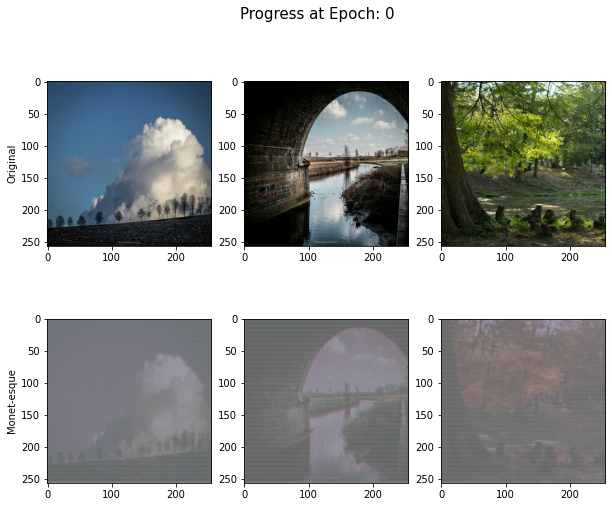

The second row shows what the Monet generator is creating before any training is done


In [12]:
def showProgress(epoch = 0):
    fig, ax = plt.subplots(2, numImages, figsize = (10, 8))
    fig.suptitle('Progress at Epoch: {0}'.format(epoch), fontsize = 15)

    makeImageRow(ax, 0, photo_ds, generate = True)
    ax[0, 0].set_ylabel('Original', fontsize='10')
    ax[1, 0].set_ylabel('Monet-esque',  fontsize='10')

    plt.show()

showProgress()
print("The second row shows what the Monet generator is creating before any training is done")

**Create the CycleGAN model**

During the model fit in the cell below, this specific training cycle will be activated. A unique training cycle is necessary to enable the feedback loop between the generator and discriminator. The tutorial's train step function has been changed to remove all of the code that teaches the model how to turn Monet paintings into photographs.

In [13]:
class PaintingCycleGan(keras.Model):
    def __init__(self, m_generator, p_generator, m_discriminator, lambda_cycle=10):
        super(PaintingCycleGan, self).__init__()
        self.m_gen = m_generator
        self.p_gen = p_generator
        self.m_disc = m_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(self, m_gen_optimizer, m_disc_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(PaintingCycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    @tf.function
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent = True) as tape:
            #Cycle a photo into a Monet and then back to a photo
            fake_monet = self.m_gen(real_photo, training = True)
            cycled_photo = self.p_gen(fake_monet, training = True)

            #Try to generate a Monet from a Monet
            same_monet = self.m_gen(real_monet, training = True)

            #Call monet discriminator with a _real_ Monet
            disc_real_monet = self.m_disc(real_monet, training = True)

            #Call monet discriminator with a _fake_ Monet
            disc_fake_monet = self.m_disc(fake_monet, training = True)

            #Get generator loss on fake Monet
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)

            #Get loss on the photo that was turned into a Monet and back
            total_cycle_loss = self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            #Add previous two losses to the loss on the Monet generated from a Monet
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + \
                self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
                
            #Get discriminator loss between real Monet and fake one
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)

        # Calculate the gradients for generator and discriminator
        m_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        m_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(m_generator_gradients, self.m_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(m_discriminator_gradients, self.m_disc.trainable_variables))

        return {"monet_gen_loss": total_monet_gen_loss,  "monet_disc_loss": monet_disc_loss}


**Loss Functions**

The PaintingCycleGan class is defined in the cell right above this one, and the various loss functions are defined in the cell below, where they will be supplied to the compile method.

In [14]:
def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits = True, 
        reduction = tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits = True, 
        reduction = tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits = True, 
        reduction = tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

    return (real_loss + generated_loss) * 0.5

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    cycleLoss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * cycleLoss

def identity_loss(real_image, same_image, LAMBDA):
    identLoss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * identLoss

In [15]:
lr_fn = tf.keras.optimizers.schedules.ExponentialDecay(
    1e-4,
    decay_steps = 300,
    decay_rate = 0.96,
    staircase = True)

#m_generator_optimizer = tf.keras.optimizers.Adam(learning_rate = lr_fn, beta_1 = 0.5, beta_2 = 0.999, epsilon=0.0001)
#m_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = lr_fn, beta_1 = 0.5, beta_2 = 0.999, epsilon=0.0001)
m_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
m_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

In order to see if the model is convergent during training, the code in the cell below defines a progress callback. Loss curves are unhelpful while training GANs, which is why. Every tenth epoch, the code as it is currently built shows a sample of three photos for both the original photograph and the Monet-style makeover.

In [16]:
progressInterval = 10

class ProgresssCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % progressInterval == 0:
            showProgress(epoch + 1)

In [17]:
cycle_gan_model = PaintingCycleGan(m_generator, p_generator, m_discriminator)

cycle_gan_model.compile(
    m_gen_optimizer = m_generator_optimizer,
    m_disc_optimizer = m_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

The model is trained for a total of 30 epochs, with progress being displayed every 10 epochs.

Epoch 1/30
300/300 [==============================] - 79s 222ms/step - monet_gen_loss: 5.6677 - monet_disc_loss: 0.6197
Epoch 2/30


2022-11-29 19:44:30.963232: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 11907, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1669751070.963159638","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 11907, Output num: 0","grpc_status":3}


300/300 [==============================] - 66s 219ms/step - monet_gen_loss: 5.5720 - monet_disc_loss: 0.6125
Epoch 3/30
300/300 [==============================] - 66s 220ms/step - monet_gen_loss: 5.5148 - monet_disc_loss: 0.6357
Epoch 4/30
300/300 [==============================] - 66s 220ms/step - monet_gen_loss: 5.4842 - monet_disc_loss: 0.6342
Epoch 5/30
300/300 [==============================] - 66s 220ms/step - monet_gen_loss: 5.4430 - monet_disc_loss: 0.6326
Epoch 6/30
300/300 [==============================] - 67s 222ms/step - monet_gen_loss: 5.4231 - monet_disc_loss: 0.6343
Epoch 7/30
300/300 [==============================] - 67s 222ms/step - monet_gen_loss: 5.3918 - monet_disc_loss: 0.6346
Epoch 8/30
300/300 [==============================] - 67s 222ms/step - monet_gen_loss: 5.3565 - monet_disc_loss: 0.6418
Epoch 9/30
300/300 [==============================] - 66s 221ms/step - monet_gen_loss: 5.3319 - monet_disc_loss: 0.6440
Epoch 10/30
300/300 [==============================

2022-11-29 19:54:28.070897: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 27232, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1669751668.070824126","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 27232, Output num: 0","grpc_status":3}


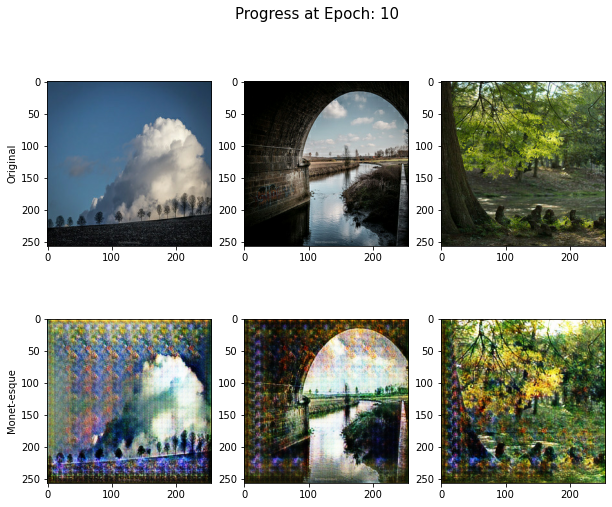

Epoch 11/30
300/300 [==============================] - 66s 221ms/step - monet_gen_loss: 5.2873 - monet_disc_loss: 0.6458
Epoch 12/30
300/300 [==============================] - 67s 223ms/step - monet_gen_loss: 5.2743 - monet_disc_loss: 0.6456
Epoch 13/30
300/300 [==============================] - 66s 221ms/step - monet_gen_loss: 5.2588 - monet_disc_loss: 0.6480
Epoch 14/30
300/300 [==============================] - 66s 221ms/step - monet_gen_loss: 5.2460 - monet_disc_loss: 0.6459
Epoch 15/30
300/300 [==============================] - 66s 219ms/step - monet_gen_loss: 5.2588 - monet_disc_loss: 0.6392
Epoch 16/30
300/300 [==============================] - 66s 221ms/step - monet_gen_loss: 5.2766 - monet_disc_loss: 0.6417
Epoch 17/30
300/300 [==============================] - 67s 222ms/step - monet_gen_loss: 5.2374 - monet_disc_loss: 0.6435
Epoch 18/30
300/300 [==============================] - 66s 221ms/step - monet_gen_loss: 5.2713 - monet_disc_loss: 0.6393
Epoch 19/30
300/300 [===========

2022-11-29 20:05:33.919171: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 44063, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1669752333.919059722","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 44063, Output num: 0","grpc_status":3}


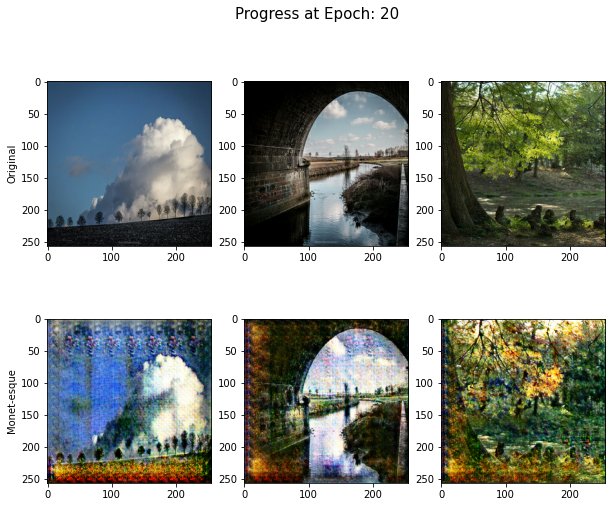

Epoch 21/30
300/300 [==============================] - 67s 223ms/step - monet_gen_loss: 5.2244 - monet_disc_loss: 0.6381
Epoch 22/30
300/300 [==============================] - 67s 222ms/step - monet_gen_loss: 5.2173 - monet_disc_loss: 0.6383
Epoch 23/30
300/300 [==============================] - 66s 221ms/step - monet_gen_loss: 5.2151 - monet_disc_loss: 0.6383
Epoch 24/30
300/300 [==============================] - 66s 221ms/step - monet_gen_loss: 5.2089 - monet_disc_loss: 0.6371
Epoch 25/30
300/300 [==============================] - 66s 220ms/step - monet_gen_loss: 5.2041 - monet_disc_loss: 0.6386
Epoch 26/30
300/300 [==============================] - 66s 221ms/step - monet_gen_loss: 5.2100 - monet_disc_loss: 0.6385
Epoch 27/30
300/300 [==============================] - 67s 222ms/step - monet_gen_loss: 5.1952 - monet_disc_loss: 0.6418
Epoch 28/30
300/300 [==============================] - 66s 221ms/step - monet_gen_loss: 5.2598 - monet_disc_loss: 0.6270
Epoch 29/30
300/300 [===========

2022-11-29 20:16:40.979533: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 60894, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1669753000.979467700","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 60894, Output num: 0","grpc_status":3}


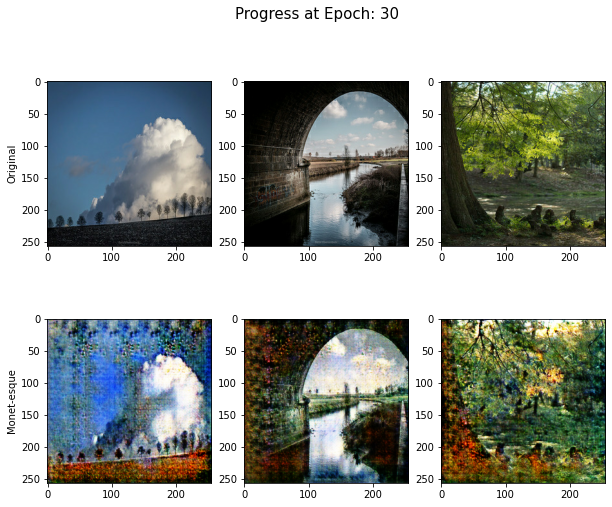

In [18]:
numEpochs = 30
monet_ds = monet_ds.shuffle(5, seed = RANDOM_SEED, reshuffle_each_iteration = False)

hist = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs = numEpochs, verbose = True, callbacks = [ProgresssCallback()]
)

if numEpochs % progressInterval != 0:
    showProgress(numEpochs)

In [19]:
import PIL

try:
    os.mkdir(TEMP_DIR)
except:
    pass

for i, img in enumerate(photo_ds):
    prediction = m_generator(img, training = False)[0].numpy()
    prediction = decodeImage(prediction, maxValue = 255)
    im = PIL.Image.fromarray(prediction)
    im.save(os.path.join(TEMP_DIR, str(i) + ".jpg"))

2022-11-29 20:37:06.418412: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 4002186, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1669754226.418123286","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 4002186, Output num: 0","grpc_status":3}


In [20]:
import shutil
shutil.make_archive("/kaggle/working/images", "zip", TEMP_DIR)

'/kaggle/working/images.zip'

# Results and takeways

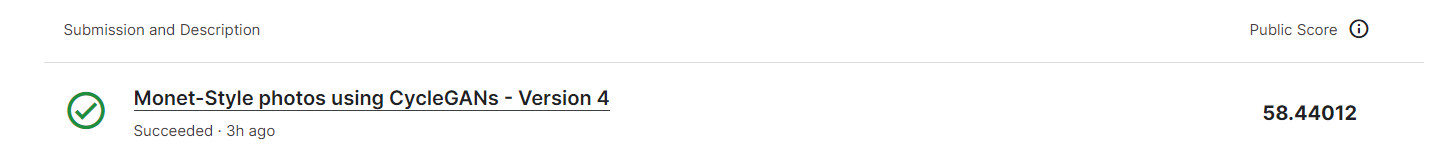
Visibly, the photos seem "over"trained," but there was not enough time to explore deeper.

After adjusting the hyperparameters, the final model did not significantly deviate from the tutorial sample, with the only exceptions being the removal of the last down sample and first up sample layers in the generator and a change in the standard deviation for the kernel and gamma initializers from 0.02 to 0.05.

The largest score improvement was seen when the standard deviation was changed, which, in my opinion, was caused by giving somewhat more color information than when it was set at 0.02. It was attempted to use larger numbers, like 0.1, however this led to severe color blooming. By training for fewer epochs, this blooming could be reduced.

**Hyperparameter Tuning**

One of the hyperparameters employed in this study was the learning rate. An exponential decay learning rate was employed, as was previously mentioned. When I first ran the tutorial's model, it seemed like there were too many color "blooms" in the faux Monets, thus the learning rate scheduler was added. In order to address this, I proposed the theory that the model's learning rate was not progressively slowing down, which was the root cause of the blooms brought on by the model's persistent overshooting of its target. Prior to settling on a value of 2e-5 with a step count of 50, several other beginning learning rates were tested.

Additionally, setting "reshuffle each iteration" to True seems to have a negative impact on the generator's performance, thus it was left at False.


# Conclusion

**Suggestions**

Another thing that could be done better is to use a "dual head" discriminator. This was a method I was not familiar with prior to competing in this competition, but it was evident in a handful of the high scoring submissions.

Then, with fewer epochs (ideally 20), I'd like to submit the same model and hyperparameter adjustment. I think the outcomes are more aesthetically pleasing.To check how the Kaggle scoring algorithm evaluates these would be interesting.

# References 

* [Jang, A. (2020, November 9). Monet CycleGAN Tutorial. Kaggle](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook)

* [Chollet, F. (2020, July 30). Image-to-image translation with CycleGAN. Keras](https://keras.io/examples/generative/cyclegan/)

* [Generative adversarial network. (2021, October 15). In Wikipedia](https://en.wikipedia.org/wiki/Generative_adversarial_network)
